In [1]:
%load_ext autoreload
%autoreload 2
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from ag_utils import Corpus
from ag_utils import parse_ag_file
from ag_utils import parse_node_properties

from public_data import gene_dataset

from models import NN, GCN, GCN_LSTM, GCN_BiGRU
from model_utils import train, predict_prob, evaluate_performance

In [2]:
# parse attack graph file generated by MulVAL tool
attack_graph_path = '../mulval_attack_graph/AttackGraph.dot'
nodes, edges, node_properties = parse_ag_file(attack_graph_path)
node_dict = parse_node_properties(nodes, node_properties)

# save node label into corpus object
corpus = Corpus(node_dict)
num_tokens = corpus.get_num_tokens()
node_features = corpus.get_node_features()
node_types = corpus.get_node_types()
vocab_size = len(corpus.dictionary)
print('vocab_size: ', vocab_size)
print('num_tokens: ', num_tokens)
print('node_features shape: ', node_features.shape)


vocab_size:  57
num_tokens:  118
node_features shape:  torch.Size([26, 57])


In [3]:
# statistics of the encoded attack graph
num_nodes = len(nodes)
print('num_nodes: ', num_nodes)

num_node_features = node_features.shape[1]
print('num_node_features: ', num_node_features)

num_edges = len(edges)
print('num_edges: ', num_edges)

action_nodes = corpus.get_action_nodes()
action_node_idx = list(action_nodes.keys())
num_action_nodes = len(action_node_idx)
print('action_node_idx: ', action_node_idx)
print('num_action_nodes: ', num_action_nodes)

# var 'action_mask' is used to represent the attack scenarios in attack graph (i.e., the privilege nodes)
action_mask = action_node_idx


num_nodes:  26
num_node_features:  57
num_edges:  26
action_node_idx:  [0, 2, 4, 7, 9, 12, 14]
num_action_nodes:  7


In [4]:
# adj matrix and edge index
adj_matrix = torch.zeros(len(nodes), len(nodes))

for edge in edges:
    source_node, target_node = edge
    source_index = nodes.index(source_node)
    target_index = nodes.index(target_node)
    adj_matrix[source_index][target_index] = 1

edge_index = adj_matrix.nonzero().t().contiguous()

assert edge_index.shape[0]==2

In [5]:
# prepare Dataset 2
num_benign = 1500
num_malic = 500
sample_method = 'public'

X, Y= gene_dataset(action_node_idx, num_nodes, num_benign, num_malic)
rt_meas_dim = X.shape[2]

# associate node features in attack graph with real-time measurements
node_feat_ts = torch.stack([node_features for _ in range(len(X))], dim=0)
X = torch.cat((node_feat_ts, X), dim=2)

num_samples = X.shape[0]
print('num_samples: ', num_samples)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42, stratify=Y_train)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

num_samples:  5000
torch.Size([3000, 26, 135]) torch.Size([3000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7])


In [6]:
# load Dataset 2 used in the paper
data_path = '../datasets/public/'
X_train = torch.load(data_path+'X_train-{}.pth'.format(sample_method))
X_val   = torch.load(data_path+'X_val-{}.pth'.format(sample_method))
X_test  = torch.load(data_path+'X_test-{}.pth'.format(sample_method))
Y_train = torch.load(data_path+'Y_train-{}.pth'.format(sample_method))
Y_val   = torch.load(data_path+'Y_val-{}.pth'.format(sample_method))
Y_test  = torch.load(data_path+'Y_test-{}.pth'.format(sample_method))
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

torch.Size([3000, 26, 135]) torch.Size([3000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7])


In [7]:

# hyperparameters for training
in_dim = X_train.shape[-1]
hidden_dim = 20
out_dim = 1
lr = 0.001
device = 'cpu'
# model initialization
models = {}
model_NN = NN(78, hidden_dim, out_dim)
model_GCN = GCN(in_dim, hidden_dim, out_dim)
model_GCN_LSTM = GCN_LSTM(in_dim, hidden_dim, out_dim, edge_index)
model_GCN_BiGRU = GCN_BiGRU(in_dim, hidden_dim, out_dim)

models['NN'] = model_NN
models['GCN'] = model_GCN
models['GCN-LSTM'] = model_GCN_LSTM
models['GCN-BIGRU'] = model_GCN_BiGRU

for name, model in models.items():
    model.name = name
    model.action_mask = action_mask

    num_epochs = 2 # early stop when overfitting observed
    print(f'{model.name} start training...')
    time_start = time.time()
    print('model: ', model) 
    train(model, lr, num_epochs, X_train, Y_train, X_val, Y_val, edge_index, rt_meas_dim, device)       
    time_end = time.time()
    print('time cost: ', time_end - time_start)  
    print(f'{model.name} training finished!')

    print(f'{model.name} accuracy on training set: {model.stat["acc_train"][-1]}')
    print(f'{model.name} accuracy on validation set: {model.stat["acc_val"][-1]}')


NN start training...
model:  NN(
  (lin1): Linear(in_features=78, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=20, bias=True)
  (out_layer): Linear(in_features=20, out_features=1, bias=True)
)
time cost:  0.35019612312316895
NN training finished!
NN accuracy on training set: 0.7592857142857142
NN accuracy on validation set: 0.7624285714285715
GCN start training...
model:  GCN(
  (conv1): GCNConv(135, 20)
  (conv2): GCNConv(20, 20)
  (classifier): Linear(in_features=20, out_features=1, bias=True)
)
time cost:  0.18828487396240234
GCN training finished!
GCN accuracy on training set: 0.7402380952380953
GCN accuracy on validation set: 0.7441428571428571
GCN-LSTM start training...
model:  GCN_LSTM(
  (conv1): GCNConv(135, 20)
  (conv2): GCNConv(20, 20)
  (classifier): Linear(in_features=20, out_features=1, bias=True)
)
time cost:  0.20625996589660645
GCN-LSTM training finished!
GCN-LSTM accuracy on training set: 0.7616666666666667
GCN-LSTM accuracy on validation

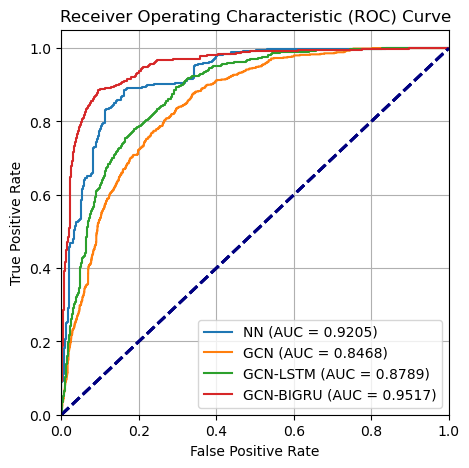

In [8]:
#plot the roc curve
from sklearn.metrics import roc_curve, auc
fig, ax = plt.subplots(figsize=(5, 5))
for name, model in models.items():
    prob = predict_prob(model, X_test, edge_index)
    y_probs = prob.view(-1, 2)

    fpr, tpr, thresholds = roc_curve(Y_test.view(-1), y_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label='{} (AUC = {:.4f})'.format(model.name, roc_auc))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc="lower right")
ax.grid()
plt.show()


In [9]:
metrics = evaluate_performance(models, X_test, Y_test, edge_index, device)
df = pd.DataFrame(metrics)
print(df)

       model    TN    FP   FN   TP precision  recall      f1     auc     fpr  \
0         NN  4669  1631   69  631    0.6322  0.8213  0.6360  0.9205  0.2589   
1        GCN  4632  1668  142  558    0.6105  0.7662  0.6090  0.8468  0.2648   
2   GCN-LSTM  4773  1527  123  577    0.6246  0.7910  0.6321  0.8789  0.2424   
3  GCN-BIGRU  5288  1012   64  636    0.6870  0.8740  0.7247  0.9517  0.1606   

      fnr loss_train loss_val acc_train acc_val accuracy  
0  0.0986     0.7045   0.6890    0.7593  0.7624   0.7571  
1  0.2029     1.0549   1.0550    0.7402  0.7441   0.7414  
2  0.1757     0.9874   0.9875    0.7617  0.7606   0.7643  
3  0.0914     0.5441   0.5363    0.8442  0.8536   0.8463  


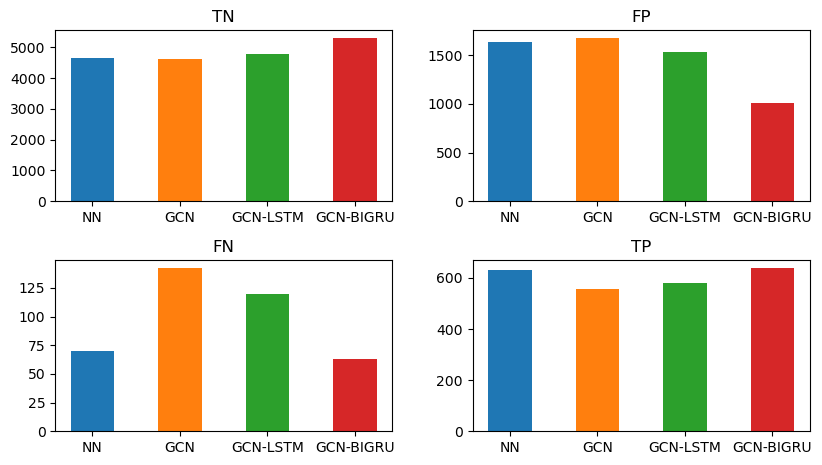

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs = axs.ravel()
bar_width = 0.5
labels = ['TN', 'FP', 'FN', 'TP']

for i, label in enumerate(labels):
    for j, name in enumerate(models):
        rects = axs[i].bar(j, metrics[j][label], width=bar_width, label=name)
    axs[i].set_xticks(np.arange(len(models)))
    axs[i].set_xticklabels(models.keys())
    for tick in axs[i].xaxis.get_major_ticks():
        tick.label1.set_fontsize(10)
    axs[i].set_title(label)

handles, labels = axs[0].get_legend_handles_labels()

plt.tight_layout(rect=[0, 0,1.7, 0.95])
plt.show()



In [11]:
# robustness evaluation
for i in range(Y_test.shape[0]):
    for j in range(len(action_mask)):
        if Y_test[i, j] == 1:
            for k in range(rt_meas_dim):
                X_test[i, action_mask[j],-rt_meas_dim+k] += torch.normal(mean=0, std=0.01, size=(1,)).item()

metrics = evaluate_performance(models, X_test, Y_test, edge_index, device)
df = pd.DataFrame(metrics)
print(df)

       model    TN    FP   FN   TP precision  recall      f1     auc     fpr  \
0         NN  4669  1631   70  630    0.6319  0.8206  0.6357  0.9181  0.2589   
1        GCN  4630  1670  142  558    0.6103  0.7660  0.6087  0.8466  0.2651   
2   GCN-LSTM  4771  1529  120  580    0.6252  0.7929  0.6328  0.8787  0.2427   
3  GCN-BIGRU  5288  1012   63  637    0.6873  0.8747  0.7250  0.9509  0.1606   

      fnr loss_train loss_val acc_train acc_val accuracy  
0  0.1000     0.7045   0.6890    0.7593  0.7624   0.7570  
1  0.2029     1.0549   1.0550    0.7402  0.7441   0.7411  
2  0.1714     0.9874   0.9875    0.7617  0.7606   0.7644  
3  0.0900     0.5441   0.5363    0.8442  0.8536   0.8464  


In [12]:
from torch_geometric.data import Data
from torch_geometric.explain import GNNExplainer, Explainer

# individual case analysis
found = False
while not found:
    indi_case_id = torch.randint(0, X_test.shape[0], (1,)).item()
    y_true = Y_test[indi_case_id]
    if y_true[2] != 0:
        found = True
        print('indi_case_id: ', indi_case_id)
indi_case_x = X_test[indi_case_id]

indi_case_id:  528


model prob_ts: 
 tensor([0.3658, 0.0435, 0.8075, 0.0614, 0.4954, 0.3881, 0.0211],
       grad_fn=<IndexBackward0>)
y_true:  tensor([0., 0., 1., 0., 0., 0., 0.])


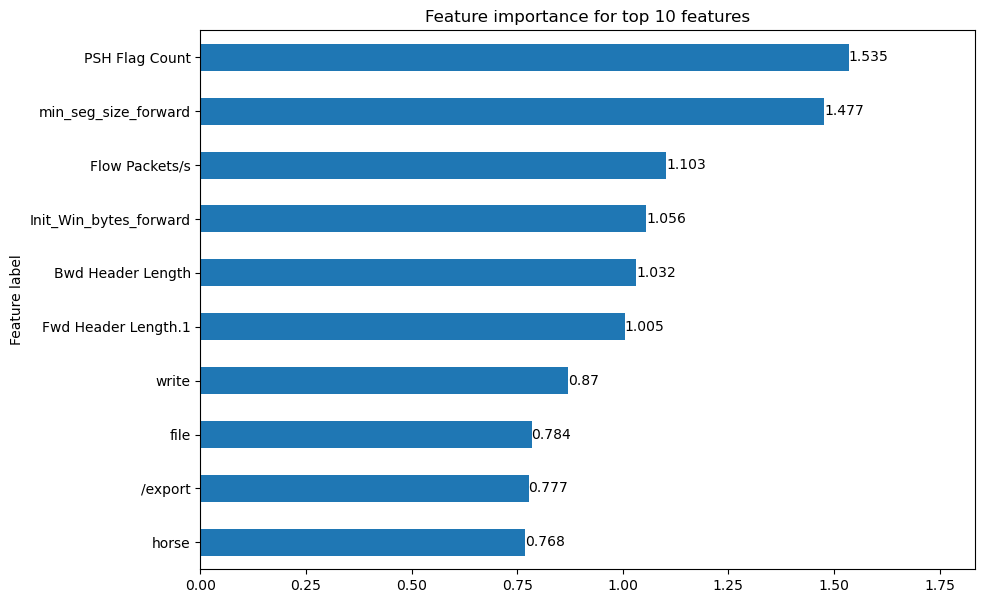

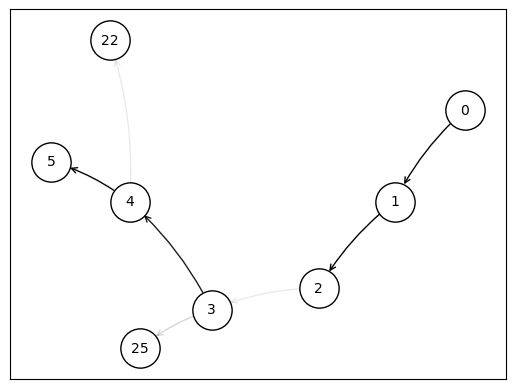

In [13]:
# Explainability visualization

model_to_explain = model_GCN_BiGRU
model_to_explain.eval()
if model.name in ['GAT']:
    indi_case_x = indi_case_x.view(-1, in_dim)
prob_ts = torch.sigmoid(model_to_explain(indi_case_x, edge_index))[action_mask]

print('model prob_ts: \n', prob_ts)
print('y_true: ', y_true)

data = Data(x=X_test[indi_case_id], edge_index=edge_index)

explainer = Explainer(
    model=model_to_explain,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='raw',
    ),

)

feat_labels_ag = corpus.dictionary.idx2word.values()
feat_labels_ag = list(feat_labels_ag)
feat_labels_rtm = pd.read_csv('../datasets/public/CICIDS-2017.csv').columns.tolist()[:-1]
feat_labels_rtm = [feat.strip() for feat in feat_labels_rtm]
feat_labels = feat_labels_ag + feat_labels_rtm

compromised_node = action_node_idx[np.where(y_true==1)[0].item()]
explanation = explainer(data.x, data.edge_index, index=compromised_node)

explanation.visualize_feature_importance(feat_labels=feat_labels, top_k=10)
explanation.visualize_graph()